# Data exercise: Explore sound recordings

In this data exercise, we will apply the concepts that we have learned so far to analyze different types of sounds.

In the [`BOAT_exercises/example_wave` folder](https://drive.google.com/drive/u/0/folders/1Qk9LF3tdJHySdgSfyWVjbjPOfk2ODoMO), you will find a collection of many wav files. Download the files assigned to your group to begin exploring working with these real-world data!

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.io.wavfile as wavfile

from pathlib import Path
import IPython.display as ipd
import ipywidgets as widgets

In [19]:
from IPython.display import display, HTML

## Read a `.wav` file

Sound recording can come in many different file formats, but `.wav` files are by far the commonest. You can use the example code below to read in the samples from an example `.wav` file.

In [20]:
wav_filename = "05.wav"  # Swap out the filename
wav_file_path = Path(wav_filename)

# Check if this file exists -- if not, this will raise an error!
assert(wav_file_path.exists())

Let's first play this recording to see how it sounds like:

In [21]:
ipd.Audio(wav_file_path)

How do the recording looks like as a time series? Let's first load the recording samples and check some basic properties of the recording:

In [31]:
sample_rate, audio_data = wavfile.read(wav_file_path) # Here we load our audio file as an array of values characterized by a sampling rate
audio_duration = audio_data.shape[0]/sample_rate
print(f"Reading in audio that is {audio_duration:.2f} sec long, "
      f"with a sampling rate of {sample_rate} Hz")

Reading in audio that is 3.99 sec long, with a sampling rate of 48000 Hz


In [23]:
# if your file is REALLY long, you can extract out a section by simply indexing the data
start_time = 60
end_time = 120
audio_data = audio_data[int(sample_rate*(start_time)):int(sample_rate*(end_time))]
audio_duration = audio_data.shape[0]/sample_rate
print(f"Reading in audio that is {audio_duration:.2f} sec long, "
      f"with a sampling rate of {sample_rate} Hz")

Reading in audio that is 0.00 sec long, with a sampling rate of 48000 Hz


In [32]:
# To plot the time correctly, we need to make a time vector
step_size = 1
time_vec = np.arange(audio_data.shape[0]) / sample_rate

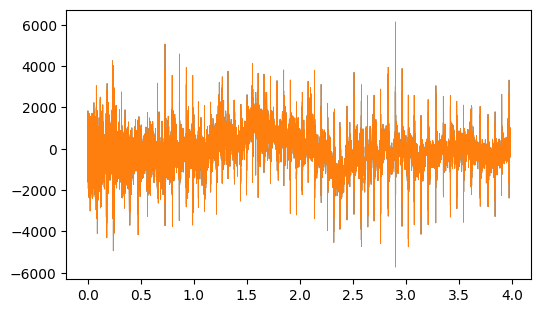

In [33]:
plt.figure(figsize=(6, 3.5))
plt.plot(time_vec, audio_data, lw=0.5)
plt.show()

Question 1: Do the values above make sense? Think about how sound is recorded in terms of the +/- oscillations of a microphone or hydrophone membrane. Are the above values showing those +/- oscillations or are they all +?

If they are all +, this is because the samples are coded as 8-bit integer, so we have to shift and scale them to return to the original voltage range typically assumed as -1 to +1 for simplicity.

If they do oscillate from + to - but the values are still really large, we have to only scale them to return to the original voltage range

In [34]:
# Check data type (dtype)
audio_data.dtype # This property of audio_data shows us whether the file was encoded using 8-bit or 16-bit depth

dtype('int16')

Question 2: Are there multiple channels? plt.plot() will plot each channel as a separate signal and one channel may dominate the other and make it invisible

Multi-channel recordings may be recorded using arrays or even simple stereo microphones. Channels will appear as columns while samples will appear as rows

In [35]:
# Check data shape (shape)
audio_data.shape # This is the shape of the .wav file array where the first value is the number of rows and the second value is the number of columns

(191321, 2)

In [36]:
## If your data is indeed multi-channel, select any specific channel (or column) for simplicity of downstream analysis
column = 1 # Play around and see whether each channel recorded the same thing; if not, how do they differ?
audio_data = audio_data[:,column]


```{Tip}
:class: tip
This is also why it is important to **read the documentations** when you use existing libraries! Take a look at the [`scipy.io.wavfile.read` documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html) to see all the functionalities and cautions this function offer
```

In [37]:
bit_depth = 16 # Replace this with the bit depth for YOUR file 

In [38]:
# Scale audio samples back to voltage
if bit_depth==8:
    audio_data = (audio_data.astype(float) - 2**(bit_depth-1)) / 2**(bit_depth-1) # [0, 255] -> [-1, 1]
if bit_depth==16:
    audio_data = (audio_data.astype(float)) / 2**(bit_depth-1) # [-32768, 32767] -> [-1, 1]

print(f'Range of values in audio file are {audio_data.min()} to {audio_data.max()}')

Range of values in audio file are -0.174591064453125 to 0.187255859375


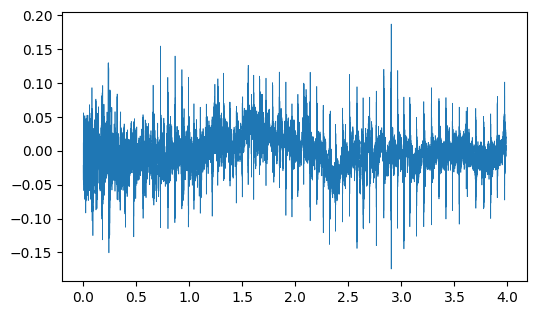

In [39]:
plt.figure(figsize=(6, 3.5))
plt.plot(time_vec, audio_data, lw=0.5)
plt.show()

## Plot the spectrogram

Plotting the spectrogram is often one of the first steps to explore a new recording. Below let's use a widget to see what's in this file.

In [40]:
def plot_audio_segment(start_time, duration, nfft):
    segment_duration = duration
    
    end_time = start_time + segment_duration
    start_idx = int(start_time * sample_rate)
    end_idx = int(end_time * sample_rate)
    segment_time = time_vec[start_idx:end_idx]
    segment_audio = audio_data[start_idx:end_idx]

    fig, ax = plt.subplots(2, 1, figsize=(8, 6))

    cur_ax = ax[0]
    cur_ax.plot(segment_time, segment_audio, lw=0.5)
    cur_ax.set_xlim(start_time, end_time)
    cur_ax.set_title(f"Time series", fontsize=16)
    cur_ax.set_ylabel("Voltage (V)")
    time_series_xticks = ax[0].get_xticks()[ax[0].get_xticks()<=(end_time+1e-12)]

    cur_ax = ax[1]
    Pxx, freqs, bins, im = cur_ax.specgram(
        segment_audio, Fs=sample_rate, NFFT=nfft,
        cmap='jet', vmin=-120, vmax=-40)
    cur_ax.set_title(f"Spectrogram", fontsize=16)
    cur_ax.set_xticks(time_series_xticks - start_time, time_series_xticks.round(2))
    cur_ax.set_yticks(np.linspace(0, sample_rate/2, 5), (np.linspace(0, sample_rate/2, 5)).astype(int))
    cur_ax.set_xlim(0, segment_duration)
    cur_ax.set_ylabel("Frequency (Hz)")
    cur_ax.set_xlabel("Time (s)", fontsize=14)

    fig.tight_layout()

    plt.show()

In [41]:
start_slider = widgets.IntSlider(
    value=33,
    min=0,
    max=np.floor(audio_duration).astype(int),
    step=step_size,
    description="Start (s)",
    continuous_update=False,
    style={'description_width': 'initial'} 
)

duration_slider = widgets.IntSlider(
    value=1,
    min=1,
    max=np.ceil(audio_duration).astype(int),
    step=step_size,
    description="Duration (s)",
    continuous_update=False,
    style={'description_width': 'initial'} 
)


nfft_slider = widgets.IntSlider(
    value=256,
    min=256,
    max=2048,
    step=256,
    description="NFFT",
    continuous_update=False,
    style={'description_width': 'initial'} 
)

widgets.interact(plot_audio_segment, start_time=start_slider, duration=duration_slider, nfft=nfft_slider)

interactive(children=(IntSlider(value=3, continuous_update=False, description='Start (s)', max=3, style=Slider…

<function __main__.plot_audio_segment(start_time, duration, nfft)>

## Quantify the sound level

Knowing how the recording "looks" like, let's now try to quantify the sound samples.

By referencing the tutorials on [hydrophone](acoustics-receiver_hydrophone_sensitivity), [sound metrics](acoustics-receiver_metrics), [decibel](primer-decibel), and [statisics](REF):

- Could you estimate what the RMS SPL of this recording is?

- What are some pieces of information you may need in addition to the recording file itself?

## Analyzing the sound spectrum

In addition to the sound level, in [time-frequency analysis](REF) we have learned how to calculate the spectral content of the sound.

- Could you compute the spectrum of the recording?

- Does the spectrum look like what you would expect based on what you saw above in the spectrogram?

- If the spectrum does not seem to reflect the interesting signal you saw on the spectrogram, why? How can you "fix" it? (\* Hint: is it reasonable to throw in the entire recording when computing the spectrum?)